In [205]:
from theano import shared
from os import path
import json
import pymc3 as pm
import pandas as pd
import numpy as np
import scipy as sp
import pickle
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline

In [206]:
engine = create_engine('sqlite:///tab.db')
conn = engine.connect()
dfo = pd.read_sql_table('race', conn)
df = dfo[dfo.distance == meeting['raceDistance']]
df.describe()

,id,age,race_number,number_of_starters,draw,margin,distance,handicap,starting_position,odds,time
count,414.000000,414.000000,414.000000,414.000000,414.0,414.000000,414.0,414.000000,414.000000,401.000000,414.000000
mean,1712.618357,4.939614,4.483092,11.746377,0.0,6.422464,1600.0,57.292271,6.355072,21.387032,99.317874
std,783.049604,1.688510,2.412328,3.166245,0.0,10.266233,0.0,2.524042,3.849092,21.407531,9.667299
min,67.000000,2.000000,1.000000,4.000000,0.0,0.100000,1600.0,49.000000,1.000000,0.000000,0.000000
25%,1049.750000,4.000000,3.000000,10.000000,0.0,1.625000,1600.0,56.000000,3.000000,7.000000,97.700000
50%,1737.500000,5.000000,4.000000,11.000000,0.0,3.950000,1600.0,57.500000,6.000000,14.000000,99.400000
75%,2476.750000,6.000000,7.000000,14.000000,0.0,8.200000,1600.0,59.000000,9.000000,26.000000,101.375000
max,2734.000000,11.000000,11.000000,21.000000,0.0,104.500000,1600.0,68.500000,18.000000,101.000000,123.200000


In [207]:
df = df[['runner_name', 'handicap', 'time']]
df = df[(df.time > 0)]
df = df[(df.handicap > 0)]
df.describe()

,handicap,time
count,411.000000,411.000000
mean,57.299270,100.042822
std,2.531841,4.630094
min,49.000000,69.500000
25%,56.000000,97.700000
50%,57.500000,99.400000
75%,59.000000,101.400000
max,68.500000,123.200000


In [219]:
runners = pd.Categorical(df['runner_name'])
n = len(runners.unique())
print('{} unique from {}'.format(n, len(runners)))

179 unique from 411


In [220]:
time_mean = df['time'].mean()
time_std = df['time'].std()
times = (df['time'] - time_mean) / time_std
print('μ = {}'.format(time_mean))
print(time_std)
print(len(times))

μ = 100.04282238442822
4.63009411642
411


In [221]:
handicap_mean = df['handicap'].mean()
handicap_std = df['handicap'].std()
handicaps = (df['handicap'] - handicap_mean) / handicap_std
print(handicap_mean)
print(handicap_std)
print(len(handicaps))

57.299270073
2.53184102544
411


In [246]:
X = handicaps
Y = times

In [247]:
with pm.Model() as model:  
    # Hyperpriors for group nodes
    μ_a = pm.Normal('μ_a', mu=0, sd=10)
    σ_a = pm.HalfNormal('σ_a', sd=1)
    μ_b = pm.Normal('μ_b', mu=0, sd=10)
    σ_b = pm.HalfNormal('σ_b', sd=1)
    
    α = pm.Normal('α', mu=μ_a, sd=σ_a, shape=n)
    β = pm.Normal('β', mu=μ_b, sd=σ_b, shape=n)
    
    μ = pm.Deterministic('μ', 
        α[runners.codes] + β[runners.codes] * X)
    
    σ = pm.HalfNormal('σ', sd=10)

    Y_like = pm.Normal('Y_like', mu=μ, sd=σ, observed=Y)
    
    trace = pm.sample(14000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 618.34:  11%|█         | 21405/200000 [00:05<00:44, 4018.32it/s]
Convergence archived at 21800
Interrupted at 21,800 [10%]: Average Loss = 809.51
100%|██████████| 14500/14500 [01:58<00:00, 121.97it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1e5bc2940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1eb6ac2e8>]], dtype=object)

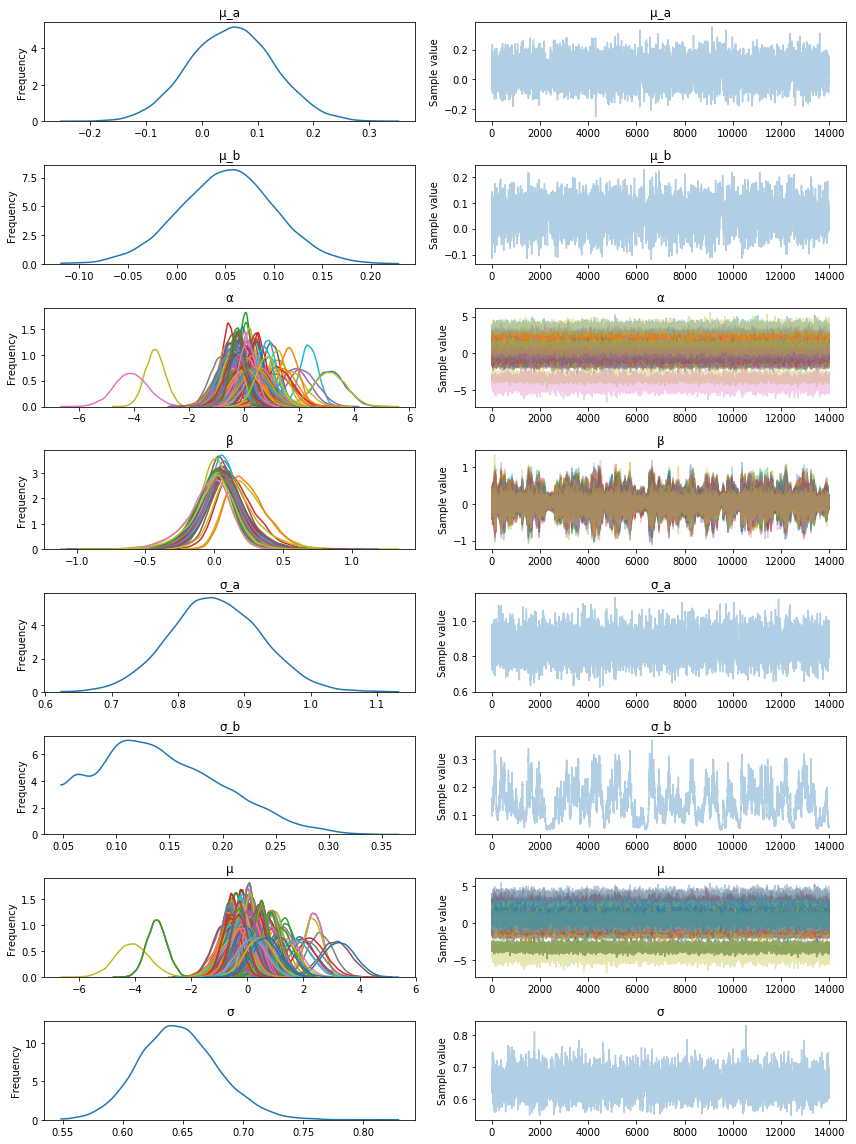

In [248]:
pm.traceplot(trace)

In [249]:
# pm.forestplot(trace)
# pm.summary(trace)
# pm.plot_posterior(trace)

In [250]:
FILE_NEXT_TO_GO = 'next_to_go.pkl'
with open(FILE_NEXT_TO_GO, 'rb') as f:
    meeting = pickle.load(f)
print(meeting.keys())
print('distance {}'.format(meeting['raceDistance']))
horses = meeting['runners']
print(len(horses))
print(horses[0].keys())

dict_keys(['raceNumber', 'raceName', 'raceDistance', 'trackDirection', 'meeting', 'skyRacing', 'hasParimutuel', 'hasFixedOdds', 'broadcastChannel', 'broadcastChannels', 'hasForm', 'hasEarlySpeedRatings', 'allIn', 'cashOutEligibility', 'allowBundle', 'willHaveFixedOdds', 'fixedOddsOnlineBetting', 'raceStartTime', 'raceClassConditions', 'apprenticesCanClaim', 'prizeMoney', 'raceStatus', 'substitute', 'results', 'pools', 'allowMulti', 'allowParimutuelPlace', 'parimutuelPlaceStatus', 'allowFixedOddsPlace', 'numberOfPlaces', 'numberOfFixedOddsPlaces', 'runners', 'oddsUpdateTime', 'fixedOddsUpdateTime', 'tips', 'ratings', 'multiLegApproximates', 'betTypes'])
distance 1600
14
dict_keys(['runnerName', 'runnerNumber', 'fixedOdds', 'parimutuel', 'silkURL', 'trainerName', 'trainerFullName', 'barrierNumber', 'riderDriverName', 'riderDriverFullName', 'handicapWeight', 'harnessHandicap', 'blinkers', 'claimAmount', 'last5Starts', 'tcdwIndicators', 'emergency', 'penalty', 'dfsFormRating', 'techFormRat

In [253]:
help(pm.sample_ppc)

Help on function sample_ppc in module pymc3.sampling:

sample_ppc(trace, samples=None, model=None, vars=None, size=None, random_seed=None, progressbar=True)
    Generate posterior predictive samples from a model given a trace.
    
    Parameters
    ----------
    trace : backend, list, or MultiTrace
        Trace generated from MCMC sampling
    samples : int
        Number of posterior predictive samples to generate. Defaults to the
        length of `trace`
    model : Model (optional if in `with` context)
        Model used to generate `trace`
    vars : iterable
        Variables for which to compute the posterior predictive samples.
        Defaults to `model.observed_RVs`.
    size : int
        The number of random draws from the distribution specified by the
        parameters in each sample of the trace.
    
    Returns
    -------
    samples : dict
        Dictionary with the variables as keys. The values corresponding
        to the posterior predictive samples.



In [254]:
for horse in horses:
    horse_name = horse['runnerName']
    print(horse_name)
    
    if horse_name not in runners:
        print('skipping...')
        continue

    print('sampling for data...')
    with model:
        post_pred = pm.sample_ppc(trace, samples=500)
    print(post_pred['Y_like'].shape)
    
    break


100%|██████████| 500/500 [00:00<00:00, 2531.52it/s]

GHARRY WALLAH
skipping...
TOW ROPE
skipping...
DIAMONDS FOR ALL
sampling for data...


(500, 411)
